# Adversarial Acoustics - Decoding
This notebook looks further at the spectrogram, opening up the intermediate state and the process of decoding as a site of intervention. 

In the following cells you’ll be able to record an audio sample and produce a mel spectrogram in much the same way as the first notebook we looked at. Following this you’ll be able to download the spectrogram as an image, edit it and upload a new version to be decoded back into audio.

In [ ]:
#@title Import prerequisite libraries
import IPython.display as ipd
from google.colab import files
from PIL import Image
import numpy as np
import soundfile
import librosa

In [ ]:
#@title Prep for recording 
# Method is from https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=57xW3GSb6gv0 , only edited button messages

"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
!pip install ffmpeg-python
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Press to stop recording";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Record your audio
import scipy
from datetime import datetime
audio, sr = get_audio()

# save the audio
scipy.io.wavfile.write('recording.wav', sr, audio)

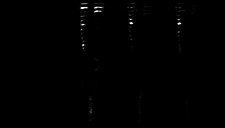

In [ ]:
#@title Generate mel spectrogram
#@markdown Produce a mel spectrogram of your recorded audio
y, sr = librosa.load('/content/recording.wav')
y_trim, _ = librosa.effects.trim(y)
n_fft=2048
hop_length=512
n_mels=128
S = librosa.feature.melspectrogram(y_trim, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
im =Image.fromarray(S).convert('F') 
im.save("/content/spectrogram.tiff")

img = Image.open('spectrogram.tiff')
out = im.convert("RGB")
out.save('spectrogram.jpeg', "JPEG", quality=90)
ipd.Image('spectrogram.jpeg')

In [ ]:
#@title Download the mel spectrogram as an image file
files.download('/content/spectrogram.tiff')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Edit your file
Using image editing software, manipulate the spectrogram. Try removing parts of the image, copying and moving pixels around or drawing on new ones. You may also want to open the image in a text editor and deleting some of the text and re-saving the file.

Encoding messages in this intermediate form is called steganography. You can find more examples of audio steganography in the decoding further materials frame in the Figjam.

Saving one-stop.tiff to one-stop.tiff
User uploaded file one-stop.tiff with length 62302 bytes


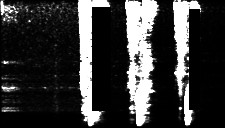

In [ ]:
#@title Upload an edited mel spectrogram image file
#@markdown Remember to preserve the .tiff file format
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file {name} with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

img = Image.open(fn)
out = img.convert("RGB")
out.save('spectrogram-edit.jpeg', "JPEG", quality=90)
ipd.Image('spectrogram-edit.jpeg')

In [ ]:
#@title Convert the mel spectrogram back to audio
img = np.array(Image.open(fn)).astype('float32')
wav = librosa.feature.inverse.mel_to_audio(img)
soundfile.write("spectrogram-edit.wav", wav, samplerate=sr)
ipd.display(ipd.Audio('spectrogram-edit.wav'))